<a href="https://colab.research.google.com/github/ZhyShe/18ma573ZhiyuanShe/blob/master/src/hw7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Verify the solution.

Verify the explicit form of $r_{t}$ given by

$$r_{t} = r_{0}e^{-\kappa t} + \mu(1 - e^{-\kappa t}) + \sigma e^{-\kappa t}\int_{0}^{t}e^{\kappa s} dW_{s}$$

Since 
$$
dr_{t} = \kappa(\mu - r_{t})dt + \sigma dW_{t}
$$
We have
$$
e^{kt}dr_t+ke^{kt}r_tdt=\kappa\mu e^{kt}dt+\sigma e^{kt} dW_t
$$
Therefore, 
$$d(e^{kt}r_t)=\kappa\mu e^{kt}dt+\sigma e^{kt} dW_t$$
As a result, do integral both sides
$$
e^{kt}r_t-r_0=\mu(e^{kt}-1)+\int_0^te^{ks}dW_s
$$
So, $$r_t=r_{0}e^{-\kappa t} + \mu(1 - e^{-\kappa t}) + \sigma e^{-\kappa t}\int_{0}^{t}e^{\kappa s} dW_{s}$$

In [0]:
import numpy as np
import pandas as pd
import scipy.optimize as so

def B(t,T,k):
  return (1 - np.exp(-k *(T-t)))/k
          
def A(t,T,k,mu,sigma):
  return (mu-sigma**2/(2*k**2))*(B(t,T,k)-(T-t))-(sigma**2/(4*k))*(B(t,T,k))**2

In [0]:
def P(t,T,k,mu,sigma,r_0):
  a=A(t,T,k,mu,sigma)-B(t,T,k)*r_0
  return np.exp(a)

def P1(t,T,k,mu,sigma,r_0):
  loc=mu*T+(r_0-mu)*(1 - np.exp(-k *T))/k
  vol=((sigma**2)/(2*(k**3)))*((2*k*T) - 3 + (4*np.exp(-1*k*T)) - np.exp(-2*k*T))
  r = np.random.normal(loc,vol,1000)
  P=np.exp(-r)
  P=np.mean(P)
  return P

def L(t,T,P):
  return (100/(T-t)) * (1/P - 1)

In [0]:
theta = [.1, .05, .003, .03]
k, mu, sigma, r_0 = theta
t=0
T=1

In [27]:
P_0=P(t,T,k,mu,sigma,r_0)
print('ZCB P(0,1) price using ZCB formula price is %f' %P_0)

ZCB P(0,1) price using ZCB formula price is 0.969508


In [28]:
P_1=P1(t,T,k,mu,sigma,r_0)
print('ZCB P(0,1) price by exact sampling is %f' %P_1)

ZCB P(0,1) price by exact sampling is 0.969507


In [29]:
L_0=L(t,T,P_0)
L_1=L(t,T,P_1)
print('LIBOR L(0,1) price using ZCB formula price is %f' %L_0)
print('LIBOR L(0,1) price using ZCB sample price is %f' %L_1)

LIBOR L(0,1) price using ZCB formula price is 3.145053
LIBOR L(0,1) price using ZCB sample price is 3.145187


In [0]:
def S(t,T,k,mu,sigma,r_0,N):
  Ps=[]
  Ps1=[]
  delta=(T-t)/N
  for j in range(N):
    Ps.append(P(t,t+(j+1)*delta,k,mu,sigma,r_0))
    Ps1.append(P1(t,t+(j+1)*delta,k,mu,sigma,r_0))
  c=delta*sum(Ps)
  c1=delta*sum(Ps1)
  a=1-P(t,T,k,mu,sigma,r_0)
  a1=1-P1(t,T,k,mu,sigma,r_0)
  return 100*a/c, 100*a1/c1
  

In [45]:
S_0,S_1=S(0,5,k,mu,sigma,r_0,10)
print("10-term swap rate with term length 1/2 year using the formula is %f" %S_0)
print("10-term swap rate with term length 1/2 year using exact sampling is %f" %S_1)

10-term swap rate with term length 1/2 year using the formula is 3.441821
10-term swap rate with term length 1/2 year using exact sampling is 3.444207


In [0]:
dfLiborRate = pd.DataFrame({'maturity (months)': [1, 2, 3, 6, 12],
                           '20081029 rate(%)': [3.1175, 3.2738, 3.4200, 3.4275, 3.4213],
                           '20110214 rate(%)': [0.2647, 0.2890, 0.3140, 0.4657, 0.7975]
                           })

libor_2008_10_29 = np.array([3.1175, 3.2738, 3.4200, 3.4275, 3.4213])
libor_maturities = [1/12, 2/12, 3/12, 6/12, 12/12]

In [0]:
def err_function(x,libor_2008_10_29,libor_maturities):
  k,mu,sigma,r_0=x
  P_0=[]
  for T in libor_maturities:
    P_0.append(P(0,T,k,mu,sigma,r_0))
  P_0=np.array(P_0)
  return sum((P_0-libor_2008_10_29)**2)
    

In [97]:
x=np.array([k,mu,sigma,r_0])
err_function(x, libor_2008_10_29,libor_maturities)

27.55805596080814

In [0]:
def calibration(libor_maturities,libor_2008_10_29):
  init_guess=np.array([.1, .05, .003, .03])
  return so.fmin(err_function, init_guess, args = (libor_2008_10_29,libor_maturities), disp = 0)

In [99]:
c_k,c_mu,c_sigma,c_r=calibration(libor_maturities,libor_2008_10_29)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
xs=[]
for T in libor_maturities:
  xs.append(P1(0,T,c_k,c_mu,c_sigma,c_r))

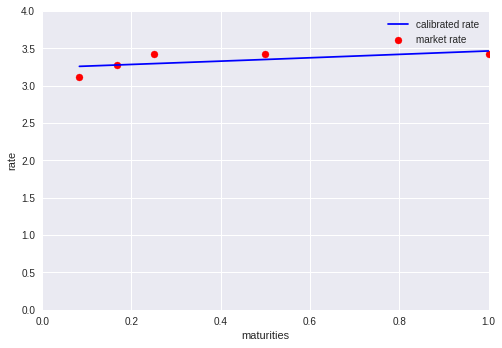

In [115]:
import matplotlib.pyplot as plt
plt.plot(libor_maturities,xs,color='b',label='calibrated rate')
plt.scatter(libor_maturities,libor_2008_10_29,color='r',label='market rate')
plt.legend()
plt.xlabel('maturities')
plt.ylabel('rate')
plt.xlim(0,1)
plt.ylim(0,4)
plt.show()


In [0]:
swap_2008_10_29 = np.array([2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772])
swap_maturities = [2, 3, 5, 7, 10, 15, 30]
swap_terms = [4, 6, 10, 14, 20, 30, 60]

In [0]:
def err1_function(x,swap_terms,swap_2008_10_29):
  k,mu,sigma,r_0=x
  s=[]
  for N in swap_terms:
    s.append(S(0,N/2,k,mu,sigma,r_0,N)[0])
  s=np.array(s)
  return sum((s-swap_2008_10_29)**2)
              

In [129]:
err1_function(x,swap_terms,swap_2008_10_29)

1.3812164823969513

In [0]:
def calibration1(swap_terms,swap_2008_10_29):
  init_guess=np.array([.1, .05, .003, .03])
  return so.fmin(err1_function, init_guess, args = (swap_terms,swap_2008_10_29), disp = 0)

In [0]:
c_k,c_mu,c_sigma,c_r=calibration1(swap_terms,swap_2008_10_29)

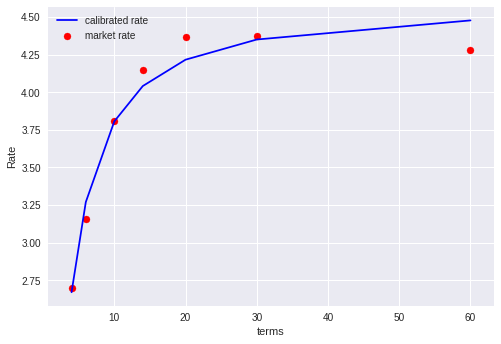

In [137]:
xs=[]
for N in swap_terms:
  xs.append(S(0,N/2,c_k,c_mu,c_sigma,c_r,N)[0])
plt.plot(swap_terms,xs,color='b',label='calibrated rate') 
plt.scatter(swap_terms,swap_2008_10_29,color='r',label='market rate')
plt.legend()
plt.xlabel('terms')
plt.ylabel('Rate')
plt.show()
  